<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-jjola00/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [3]:
def getTransforms(augmentation=False):
    mean = (0.2860,)
    std = (0.3530,)

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform

## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [4]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    train_transform, test_transform = getTransforms(augmentation)

    train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Train set size: 60000
Test set size: 10000




















































## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [5]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(28, 56, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)

        if self.useRegularization:
            self.dropout = nn.Dropout(dropout_prob)

        self.conv3 = nn.Conv2d(56, 112, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(112, 112, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(112 * 7 * 7, 224)
        self.fc2 = nn.Linear(224, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        if self.useRegularization:
            x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        out = self.fc2(x)
        return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [6]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [7]:
model = NetFashion().to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [8]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.297641  [   64/60000]
loss: 0.529992  [ 6464/60000]
loss: 0.320528  [12864/60000]
loss: 0.393441  [19264/60000]
loss: 0.441948  [25664/60000]
loss: 0.305889  [32064/60000]
loss: 0.325557  [38464/60000]
loss: 0.267943  [44864/60000]
loss: 0.325946  [51264/60000]
loss: 0.258466  [57664/60000]


Epochs:  10%|█         | 1/10 [00:38<05:49, 38.81s/it]

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.247706 

Test Error: 
 Accuracy: 89.7%, Avg loss: 0.282779 

Epoch 2:

loss: 0.300484  [   64/60000]
loss: 0.249888  [ 6464/60000]
loss: 0.170946  [12864/60000]
loss: 0.238939  [19264/60000]
loss: 0.245842  [25664/60000]
loss: 0.100018  [32064/60000]
loss: 0.188210  [38464/60000]
loss: 0.167785  [44864/60000]
loss: 0.232565  [51264/60000]
loss: 0.444775  [57664/60000]


Epochs:  20%|██        | 2/10 [01:14<04:55, 36.89s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.192023 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.242312 

Epoch 3:

loss: 0.098138  [   64/60000]
loss: 0.199760  [ 6464/60000]
loss: 0.246177  [12864/60000]
loss: 0.077696  [19264/60000]
loss: 0.225969  [25664/60000]
loss: 0.218616  [32064/60000]
loss: 0.142201  [38464/60000]
loss: 0.143042  [44864/60000]
loss: 0.160002  [51264/60000]
loss: 0.151896  [57664/60000]


Epochs:  30%|███       | 3/10 [01:50<04:15, 36.57s/it]

Train Error: 
 Accuracy: 95.3%, Avg loss: 0.134889 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.207242 

Epoch 4:

loss: 0.120728  [   64/60000]
loss: 0.167639  [ 6464/60000]
loss: 0.171890  [12864/60000]
loss: 0.170937  [19264/60000]
loss: 0.232130  [25664/60000]
loss: 0.206060  [32064/60000]
loss: 0.156176  [38464/60000]
loss: 0.138140  [44864/60000]
loss: 0.060176  [51264/60000]
loss: 0.152118  [57664/60000]


Epochs:  40%|████      | 4/10 [02:26<03:38, 36.47s/it]

Train Error: 
 Accuracy: 96.2%, Avg loss: 0.108928 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.213515 

Epoch 5:

loss: 0.029275  [   64/60000]
loss: 0.228162  [ 6464/60000]
loss: 0.077902  [12864/60000]
loss: 0.206641  [19264/60000]
loss: 0.055684  [25664/60000]
loss: 0.133558  [32064/60000]
loss: 0.127069  [38464/60000]
loss: 0.205066  [44864/60000]
loss: 0.040848  [51264/60000]
loss: 0.129010  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:02<03:00, 36.09s/it]

Train Error: 
 Accuracy: 97.0%, Avg loss: 0.085160 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.227730 

Epoch 6:

loss: 0.086311  [   64/60000]
loss: 0.034599  [ 6464/60000]
loss: 0.094837  [12864/60000]
loss: 0.049859  [19264/60000]
loss: 0.063280  [25664/60000]
loss: 0.160353  [32064/60000]
loss: 0.052911  [38464/60000]
loss: 0.152646  [44864/60000]
loss: 0.020115  [51264/60000]
loss: 0.155383  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:37<02:22, 35.71s/it]

Train Error: 
 Accuracy: 97.9%, Avg loss: 0.061596 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.221059 

Epoch 7:

loss: 0.048033  [   64/60000]
loss: 0.043821  [ 6464/60000]
loss: 0.055448  [12864/60000]
loss: 0.089337  [19264/60000]
loss: 0.066192  [25664/60000]
loss: 0.052424  [32064/60000]
loss: 0.106119  [38464/60000]
loss: 0.031281  [44864/60000]
loss: 0.027366  [51264/60000]
loss: 0.060602  [57664/60000]


Epochs:  70%|███████   | 7/10 [04:11<01:45, 35.08s/it]

Train Error: 
 Accuracy: 98.7%, Avg loss: 0.040460 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.261366 

Epoch 8:

loss: 0.050178  [   64/60000]
loss: 0.020657  [ 6464/60000]
loss: 0.058533  [12864/60000]
loss: 0.011759  [19264/60000]
loss: 0.125622  [25664/60000]
loss: 0.024820  [32064/60000]
loss: 0.026898  [38464/60000]
loss: 0.024355  [44864/60000]
loss: 0.054764  [51264/60000]
loss: 0.065218  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:45<01:09, 34.82s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.032755 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.301353 

Epoch 9:

loss: 0.011943  [   64/60000]
loss: 0.006366  [ 6464/60000]
loss: 0.048327  [12864/60000]
loss: 0.014010  [19264/60000]
loss: 0.008746  [25664/60000]
loss: 0.022430  [32064/60000]
loss: 0.064231  [38464/60000]
loss: 0.017227  [44864/60000]
loss: 0.044868  [51264/60000]
loss: 0.019114  [57664/60000]


Epochs:  90%|█████████ | 9/10 [05:20<00:34, 34.79s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.035458 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.350889 

Epoch 10:

loss: 0.020689  [   64/60000]
loss: 0.038398  [ 6464/60000]
loss: 0.091628  [12864/60000]
loss: 0.130429  [19264/60000]
loss: 0.002914  [25664/60000]
loss: 0.141745  [32064/60000]
loss: 0.003352  [38464/60000]
loss: 0.016573  [44864/60000]
loss: 0.091730  [51264/60000]
loss: 0.015229  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:54<00:00, 35.47s/it]

Train Error: 
 Accuracy: 99.3%, Avg loss: 0.019724 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.362989 

Done training!


Plotting metrics

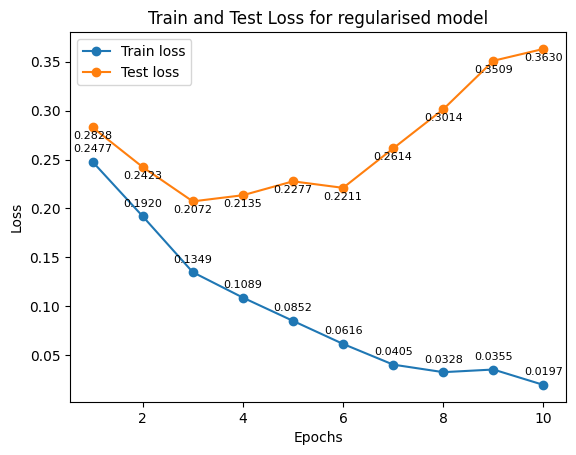

In [9]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

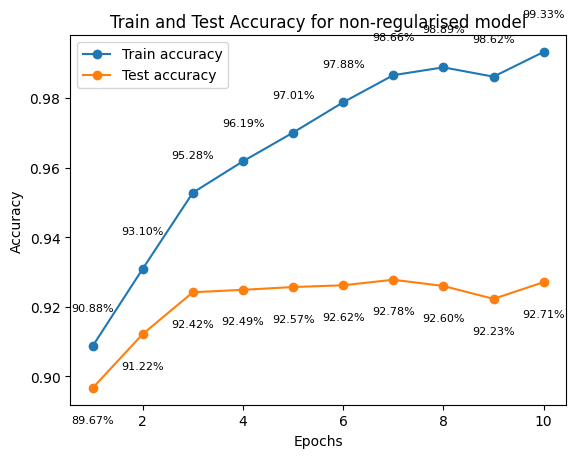

In [10]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [11]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

model = NetFashion().to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimiser, epochs
)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.304759  [   64/60000]
loss: 0.564979  [ 6464/60000]
loss: 0.451304  [12864/60000]
loss: 0.596614  [19264/60000]
loss: 0.493904  [25664/60000]
loss: 0.361200  [32064/60000]
loss: 0.298732  [38464/60000]
loss: 0.290783  [44864/60000]
loss: 0.300438  [51264/60000]
loss: 0.340828  [57664/60000]


Epochs:  20%|██        | 1/5 [00:50<03:23, 50.92s/it]

Train Error: 
 Accuracy: 88.9%, Avg loss: 0.303564 

Test Error: 
 Accuracy: 51.1%, Avg loss: 1.426472 

Epoch 2:

loss: 0.268863  [   64/60000]
loss: 0.216162  [ 6464/60000]
loss: 0.438164  [12864/60000]
loss: 0.352650  [19264/60000]
loss: 0.465559  [25664/60000]
loss: 0.233452  [32064/60000]
loss: 0.391095  [38464/60000]
loss: 0.185729  [44864/60000]
loss: 0.328707  [51264/60000]
loss: 0.348407  [57664/60000]


Epochs:  40%|████      | 2/5 [01:41<02:32, 50.97s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.235902 

Test Error: 
 Accuracy: 44.8%, Avg loss: 3.152670 

Epoch 3:

loss: 0.264711  [   64/60000]
loss: 0.180133  [ 6464/60000]
loss: 0.363550  [12864/60000]
loss: 0.191280  [19264/60000]
loss: 0.329971  [25664/60000]
loss: 0.183967  [32064/60000]
loss: 0.268793  [38464/60000]
loss: 0.331805  [44864/60000]
loss: 0.286971  [51264/60000]
loss: 0.240292  [57664/60000]


Epochs:  60%|██████    | 3/5 [02:33<01:42, 51.11s/it]

Train Error: 
 Accuracy: 92.1%, Avg loss: 0.216202 

Test Error: 
 Accuracy: 43.2%, Avg loss: 2.754446 

Epoch 4:

loss: 0.159951  [   64/60000]
loss: 0.170891  [ 6464/60000]
loss: 0.180226  [12864/60000]
loss: 0.253776  [19264/60000]
loss: 0.302544  [25664/60000]
loss: 0.139858  [32064/60000]
loss: 0.179698  [38464/60000]
loss: 0.101832  [44864/60000]
loss: 0.182771  [51264/60000]
loss: 0.227800  [57664/60000]


Epochs:  80%|████████  | 4/5 [03:24<00:51, 51.22s/it]

Train Error: 
 Accuracy: 92.9%, Avg loss: 0.196036 

Test Error: 
 Accuracy: 44.5%, Avg loss: 1.941801 

Epoch 5:

loss: 0.189445  [   64/60000]
loss: 0.060932  [ 6464/60000]
loss: 0.101664  [12864/60000]
loss: 0.141928  [19264/60000]
loss: 0.075535  [25664/60000]
loss: 0.248908  [32064/60000]
loss: 0.109683  [38464/60000]
loss: 0.095344  [44864/60000]
loss: 0.198614  [51264/60000]
loss: 0.078425  [57664/60000]


Epochs: 100%|██████████| 5/5 [04:16<00:00, 51.26s/it]

Train Error: 
 Accuracy: 93.4%, Avg loss: 0.185125 

Test Error: 
 Accuracy: 36.6%, Avg loss: 3.372758 

Done training!


Plotting metrics

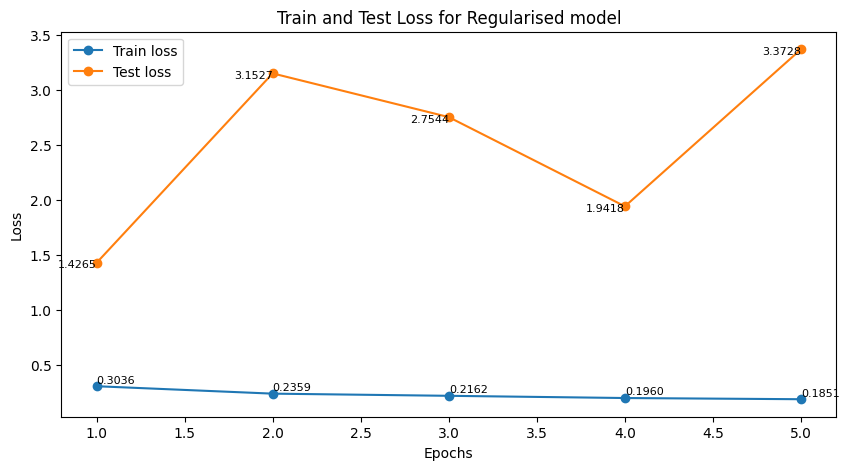

In [12]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

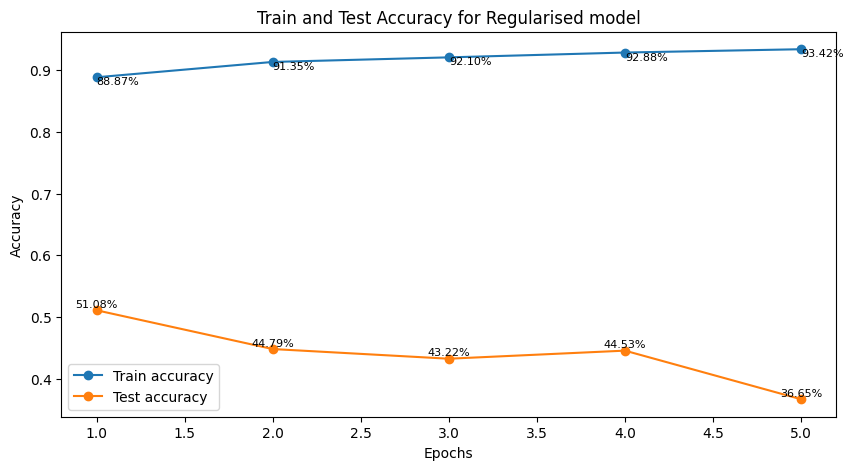

In [13]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

class NetFashion(nn.Module):
    def __init__(self):
        super(NetFashion, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = NetFashion().to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimiser, epochs
)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.318634  [   64/60000]
loss: 0.876041  [ 6464/60000]
loss: 0.663571  [12864/60000]
loss: 0.605698  [19264/60000]
loss: 0.500378  [25664/60000]
loss: 0.519216  [32064/60000]
loss: 0.690368  [38464/60000]
loss: 0.513083  [44864/60000]
loss: 0.627098  [51264/60000]
loss: 0.407917  [57664/60000]


Epochs:  20%|██        | 1/5 [00:32<02:08, 32.06s/it]

Train Error: 
 Accuracy: 87.1%, Avg loss: 0.349133 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.375478 

Epoch 2:

loss: 0.546909  [   64/60000]
loss: 0.479764  [ 6464/60000]
loss: 0.296150  [12864/60000]
loss: 0.433091  [19264/60000]
loss: 0.396667  [25664/60000]
loss: 0.344629  [32064/60000]
loss: 0.471636  [38464/60000]
loss: 0.207917  [44864/60000]
loss: 0.237239  [51264/60000]
loss: 0.419197  [57664/60000]


Epochs:  40%|████      | 2/5 [01:03<01:34, 31.58s/it]

Train Error: 
 Accuracy: 89.5%, Avg loss: 0.290065 

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.320093 

Epoch 3:

loss: 0.246574  [   64/60000]
loss: 0.524088  [ 6464/60000]
loss: 0.608497  [12864/60000]
loss: 0.585668  [19264/60000]
loss: 0.415563  [25664/60000]
loss: 0.450390  [32064/60000]
loss: 0.297501  [38464/60000]
loss: 0.375161  [44864/60000]
loss: 0.242758  [51264/60000]
loss: 0.305408  [57664/60000]


Epochs:  60%|██████    | 3/5 [01:34<01:02, 31.36s/it]

Train Error: 
 Accuracy: 89.8%, Avg loss: 0.269845 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.309296 

Epoch 4:

loss: 0.531064  [   64/60000]
loss: 0.294176  [ 6464/60000]
loss: 0.508160  [12864/60000]
loss: 0.285849  [19264/60000]
loss: 0.443139  [25664/60000]
loss: 0.498356  [32064/60000]
loss: 0.201517  [38464/60000]
loss: 0.274152  [44864/60000]
loss: 0.276078  [51264/60000]
loss: 0.337731  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:07<00:31, 31.91s/it]

Train Error: 
 Accuracy: 91.3%, Avg loss: 0.237046 

Test Error: 
 Accuracy: 89.8%, Avg loss: 0.273837 

Epoch 5:

loss: 0.286301  [   64/60000]
loss: 0.335414  [ 6464/60000]
loss: 0.343656  [12864/60000]
loss: 0.250230  [19264/60000]
loss: 0.338853  [25664/60000]
loss: 0.311730  [32064/60000]
loss: 0.245341  [38464/60000]
loss: 0.271866  [44864/60000]
loss: 0.326656  [51264/60000]
loss: 0.335118  [57664/60000]


Epochs: 100%|██████████| 5/5 [02:38<00:00, 31.75s/it]

Train Error: 
 Accuracy: 91.7%, Avg loss: 0.221759 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.262652 

Done training!


Plotting metrics

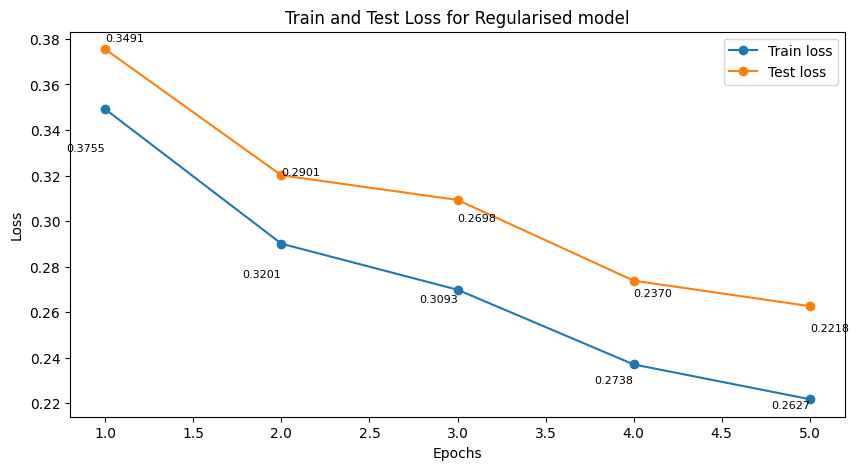

In [15]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

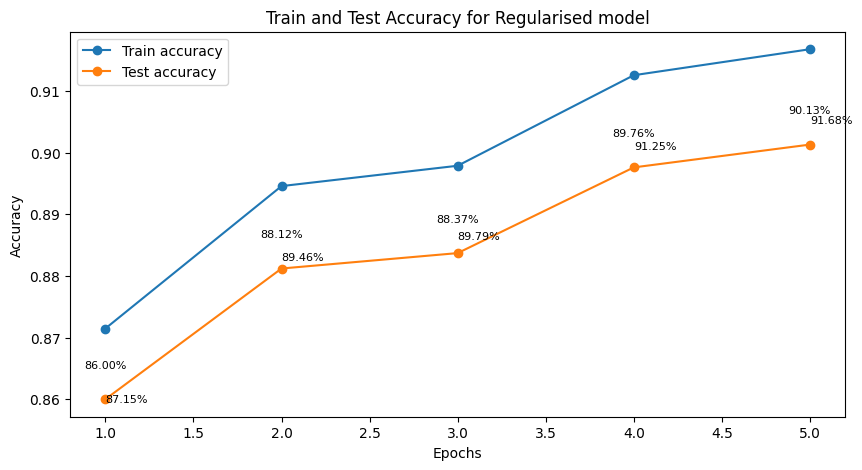

In [16]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [19]:
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion().to(device)

epochs = 5  .
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.311191  [   64/60000]
loss: 0.720502  [ 6464/60000]
loss: 0.393314  [12864/60000]
loss: 0.621951  [19264/60000]
loss: 0.569313  [25664/60000]
loss: 0.726416  [32064/60000]
loss: 0.481352  [38464/60000]
loss: 0.602498  [44864/60000]
loss: 0.569890  [51264/60000]
loss: 0.531676  [57664/60000]


Epochs:  20%|██        | 1/5 [00:33<02:15, 33.99s/it]

Train Error: 
 Accuracy: 82.7%, Avg loss: 0.458020 

Test Error: 
 Accuracy: 81.8%, Avg loss: 0.477571 

Epoch 2:

loss: 0.644137  [   64/60000]
loss: 0.595200  [ 6464/60000]
loss: 0.511118  [12864/60000]
loss: 0.400922  [19264/60000]
loss: 0.519100  [25664/60000]
loss: 0.447548  [32064/60000]
loss: 0.548962  [38464/60000]
loss: 0.365540  [44864/60000]
loss: 0.548761  [51264/60000]
loss: 0.540850  [57664/60000]


Epochs:  40%|████      | 2/5 [01:05<01:38, 32.80s/it]

Train Error: 
 Accuracy: 85.9%, Avg loss: 0.393933 

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.412797 

Epoch 3:

loss: 0.518134  [   64/60000]
loss: 0.441910  [ 6464/60000]
loss: 0.460536  [12864/60000]
loss: 0.445250  [19264/60000]
loss: 0.497066  [25664/60000]
loss: 0.545676  [32064/60000]
loss: 0.529781  [38464/60000]
loss: 0.333047  [44864/60000]
loss: 0.449048  [51264/60000]
loss: 0.716178  [57664/60000]


Epochs:  60%|██████    | 3/5 [01:36<01:03, 31.90s/it]

Train Error: 
 Accuracy: 85.8%, Avg loss: 0.400829 

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.417880 

Epoch 4:

loss: 0.648248  [   64/60000]
loss: 0.427434  [ 6464/60000]
loss: 0.620703  [12864/60000]
loss: 0.571399  [19264/60000]
loss: 0.387747  [25664/60000]
loss: 0.429688  [32064/60000]
loss: 0.446521  [38464/60000]
loss: 0.461067  [44864/60000]
loss: 0.449283  [51264/60000]
loss: 0.551982  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:09<00:32, 32.18s/it]

Train Error: 
 Accuracy: 85.9%, Avg loss: 0.390483 

Test Error: 
 Accuracy: 85.2%, Avg loss: 0.407524 

Epoch 5:

loss: 0.508523  [   64/60000]
loss: 0.431601  [ 6464/60000]
loss: 0.439754  [12864/60000]
loss: 0.533032  [19264/60000]
loss: 0.429476  [25664/60000]
loss: 0.558069  [32064/60000]
loss: 0.468253  [38464/60000]
loss: 0.513001  [44864/60000]
loss: 0.476898  [51264/60000]
loss: 0.523615  [57664/60000]


Epochs: 100%|██████████| 5/5 [02:41<00:00, 32.29s/it]

Train Error: 
 Accuracy: 86.2%, Avg loss: 0.401694 

Test Error: 
 Accuracy: 85.4%, Avg loss: 0.419771 

Done training!


Plotting metrics

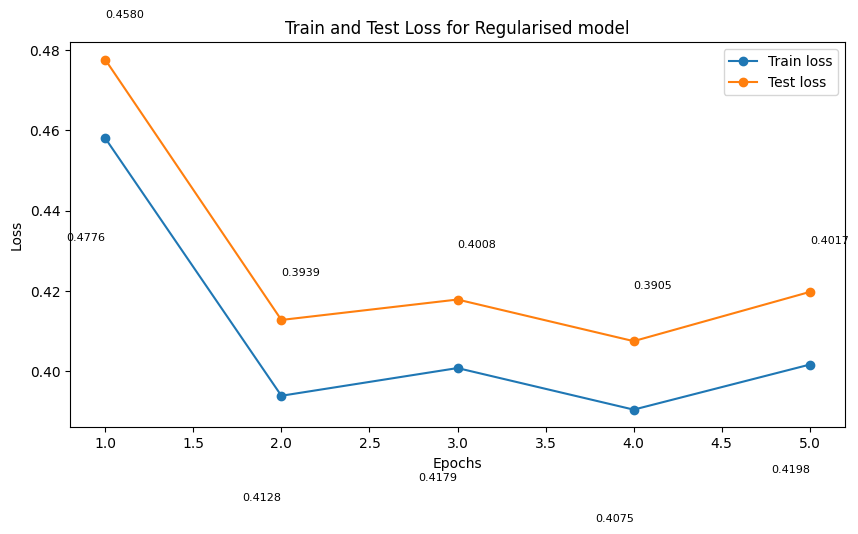

In [20]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

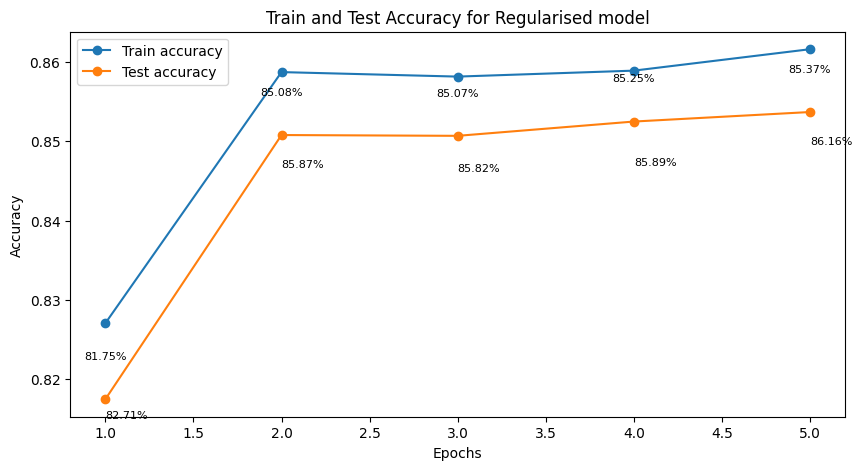

In [21]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

model = NetFashion().to(device)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 5
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimiser, epochs
)


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:

loss: 2.329714  [   64/60000]
loss: 0.625705  [ 6464/60000]
loss: 0.577855  [12864/60000]
loss: 0.568323  [19264/60000]
loss: 0.521324  [25664/60000]
loss: 0.450823  [32064/60000]
loss: 0.514743  [38464/60000]
loss: 0.598076  [44864/60000]
loss: 0.532507  [51264/60000]
loss: 0.310307  [57664/60000]


Epochs:  20%|██        | 1/5 [00:33<02:15, 33.84s/it]

Train Error: 
 Accuracy: 87.1%, Avg loss: 0.355852 

Test Error: 
 Accuracy: 86.3%, Avg loss: 0.379005 

Epoch 2:

loss: 0.400897  [   64/60000]
loss: 0.301193  [ 6464/60000]
loss: 0.480611  [12864/60000]
loss: 0.451872  [19264/60000]
loss: 0.403434  [25664/60000]
loss: 0.337741  [32064/60000]
loss: 0.297838  [38464/60000]
loss: 0.360780  [44864/60000]
loss: 0.298756  [51264/60000]
loss: 0.414534  [57664/60000]


Epochs:  40%|████      | 2/5 [01:06<01:38, 32.98s/it]

Train Error: 
 Accuracy: 89.1%, Avg loss: 0.292963 

Test Error: 
 Accuracy: 87.8%, Avg loss: 0.329336 

Epoch 3:

loss: 0.421112  [   64/60000]
loss: 0.475357  [ 6464/60000]
loss: 0.355583  [12864/60000]
loss: 0.488002  [19264/60000]
loss: 0.351653  [25664/60000]
loss: 0.403333  [32064/60000]
loss: 0.285327  [38464/60000]
loss: 0.353731  [44864/60000]
loss: 0.485378  [51264/60000]
loss: 0.406600  [57664/60000]


Epochs:  60%|██████    | 3/5 [01:37<01:04, 32.36s/it]

Train Error: 
 Accuracy: 90.4%, Avg loss: 0.257895 

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.297797 

Epoch 4:

loss: 0.380516  [   64/60000]
loss: 0.350296  [ 6464/60000]
loss: 0.430199  [12864/60000]
loss: 0.592278  [19264/60000]
loss: 0.211417  [25664/60000]
loss: 0.238708  [32064/60000]
loss: 0.540935  [38464/60000]
loss: 0.174866  [44864/60000]
loss: 0.213004  [51264/60000]
loss: 0.285340  [57664/60000]


Epochs:  80%|████████  | 4/5 [02:11<00:32, 32.84s/it]

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.241526 

Test Error: 
 Accuracy: 89.6%, Avg loss: 0.283548 

Epoch 5:

loss: 0.384588  [   64/60000]
loss: 0.349658  [ 6464/60000]
loss: 0.286595  [12864/60000]
loss: 0.244711  [19264/60000]
loss: 0.301621  [25664/60000]
loss: 0.264252  [32064/60000]
loss: 0.265309  [38464/60000]
loss: 0.245323  [44864/60000]
loss: 0.288466  [51264/60000]
loss: 0.289555  [57664/60000]


Epochs: 100%|██████████| 5/5 [02:44<00:00, 32.89s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.222696 

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.263863 

Done training!


Plotting metrics

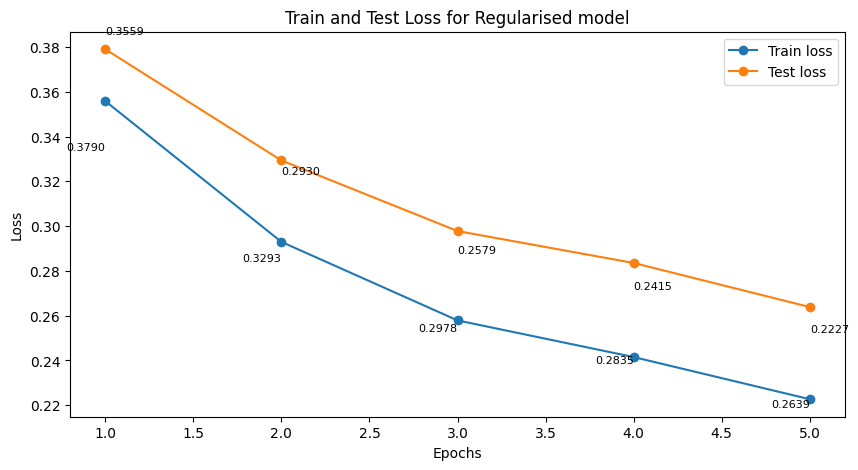

In [23]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

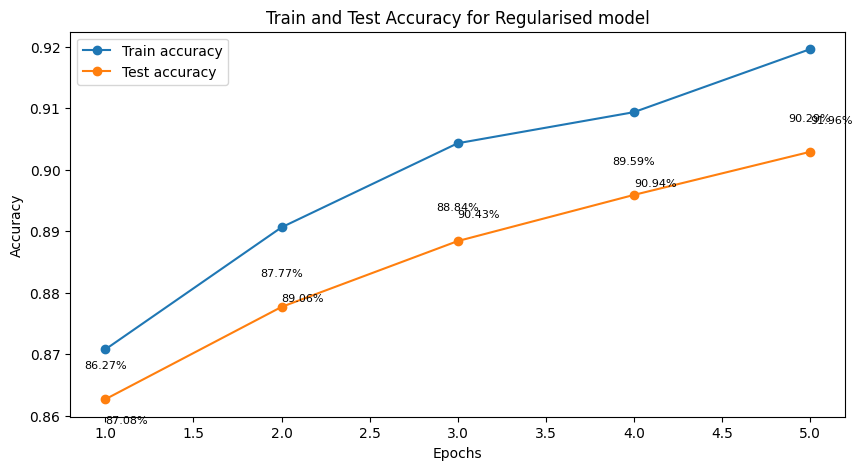

In [24]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='green'>Overfitting occurs when a model learns noise and details from the training data, reducing its ability to generalize to new data. To prevent overfitting I included data augmentation to increase dataset diversity and normalization to ensure stable training.</font>

